## Data Preprocessing and EDA

### Importing libraries

In [18]:
import pandas as pd
import seaborn as sns
import re 

import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

import spacy

# Initialize spaCy
nlp = spacy.load('en_core_web_sm')

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophia.bouchama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:

reviews_data = pd.read_csv("../data/Reviews.csv")

In [20]:
reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [21]:
reviews_data.shape

(568454, 10)

In [22]:
reviews_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

<Axes: xlabel='Score', ylabel='count'>

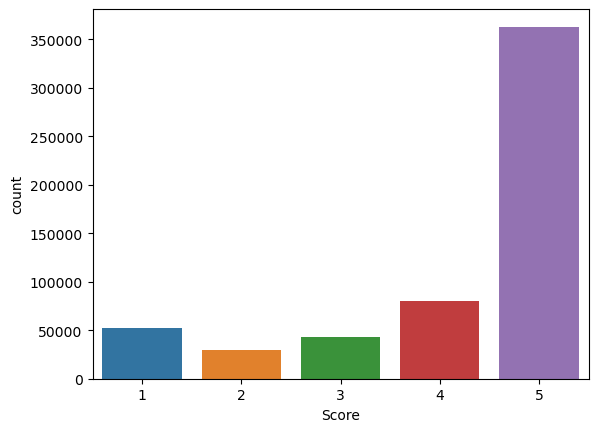

In [23]:
sns.countplot(x="Score", data=reviews_data)

<Axes: xlabel='HelpfulnessNumerator', ylabel='count'>

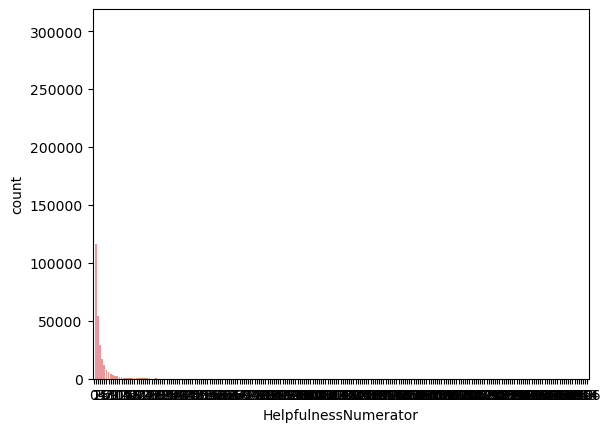

In [24]:
sns.countplot(x="HelpfulnessNumerator", data=reviews_data)

<Axes: xlabel='HelpfulnessDenominator', ylabel='count'>

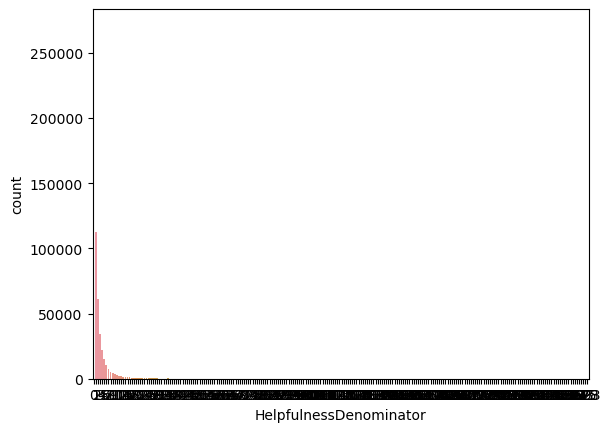

In [25]:
sns.countplot(x="HelpfulnessDenominator", data=reviews_data)

In [26]:
reviews_data.shape

(568454, 10)

In [27]:
reviews_data = reviews_data[reviews_data["HelpfulnessNumerator"] <= reviews_data["HelpfulnessDenominator"]]

In [28]:
reviews_data.shape

(568452, 10)

In [29]:
reviews_data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [30]:
reviews_data['Time'] = pd.to_datetime(reviews_data['Time'], unit='s')

In [31]:
reviews_data['Time'].head()

0   2011-04-27
1   2012-09-07
2   2008-08-18
3   2011-06-13
4   2012-10-21
Name: Time, dtype: datetime64[ns]

In [34]:
# Function to clean and preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization with spaCy
    lemmatized_tokens = [token.lemma_ for token in nlp(' '.join(filtered_tokens))]
    # Rejoin tokens into a string
    clean_text = ' '.join(lemmatized_tokens)
    return clean_text

In [44]:
reviews_data['Text'] = reviews_data['Text'].apply(preprocess_text)


KeyboardInterrupt: 

In [ ]:
reviews_data.head()